In [5]:
import os
import warnings
import numpy as np
import pandas as pd
import pdb
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.style as style
import datetime
import json
import cv2

% matplotlib inline
style.use('seaborn-whitegrid')
warnings.filterwarnings(action='once')

UsageError: Line magic function `%` not found.


## Collecting and preparing images for training
To collect and clean data for this project, I completed the steps below.
1. I used "1_save_video.py" file to record video of various hand gestures. Since the background would need to be subtracted from the images, I setup my camera in front of a plain background, stepped out of the camera's field of view, and started the recording. I then made a hand gesture and moved my hand across the camera's field of view to provide multiple different orientations of the same gesture. When finished capturing a particular hand gesture, I removed my hand from the camera's field of view for several seconds before performing a new gesture. 
2. I then trimmed the video into segments for each hand gesture. Since I recorded the background before performing each  gesture, I was able to easily cut the video.
3. I then used "2_classify_images.py" to process frames from each video segment into binary images. These binary images were then saved in directories corresponding to the gesture performed.
4. Finally, I analyzed each photo and assigned the label "good," "pure," or "poor" depending on the quality and amount of noise present in the image. A "pure" photo is one that clearly shows the performed hand gesture and shows the hand as white and the background as black. These photos have no noise in the form of white specks scattered throughout the background or black specks on the hand. These clean images provide the model with a strong foundation on which new predictions can be made. By having a firm grasp of the fundamental patterns that compose a given hand gesture, the model is able to discern the signal in the noise of a noisier images. 

In [6]:
from keras.utils import to_categorical

def process_image(path):
    """Opens image and converts to array

    Args:
        path (str): The file location of the image

    Returns:
        img (array): An array representing the image
    """

    img = cv2.imread(path)
    img = np.array(img)
    (_, img) = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)
    return img

def process_data(X_data, y_data):
    """Converts each binary frame with dimensions MxNx1 to MxNx3 to mimic RGB pixel count

    Args:
        X_data (list): List of arrays representing MxNx1 binary images 
        y_data (list): List of integers representing image classification category 

    Returns:
        X_data (array): Array of arrays representing MXNx3 binary images
        y_data (array): Array of integers representing image classification category 
    """

    X_data = np.array(X_data, dtype = 'float32')
    X_data = np.stack((X_data,)*3, axis=-1)
    X_data /= 255
    y_data = np.array(y_data)
    return X_data, y_data

def get_gest_data(relative_paths, cat_num, max_count):
    """Uses image directory path, gesture category number, and maximum gesture count to generate X_data and y_data 
    arrays for a particular gesture. If images are collected from multiple directories, each directory contributes 
    equally toward the maximum number of gesture instances allowed. 

    Args:
        relative_paths (str): Relative paths of directories containing images of particular gesture
        cat_num (int): Integer representing image classification category 
        max_count (int): Integer representing maximum number of gesture instances to keep  

    Returns:
        X_data (array): Array of arrays representing processed images
        y_data (array): Array of integers representing image classification category 
    """
    
    count_per_dir_dict = {}
    num_dirs_in_excess = 0
    count_remaining = max_count
    X_data = []
    for path in relative_paths:
        for directory, subdirectories, files in os.walk(path):
            num_files = len(files)
        count_per_dir_dict[path] = num_files
        if num_files <= max_count / len(relative_paths):
            count_remaining -= len(files)
        else:
            num_dirs_in_excess += 1
    for path in relative_paths:
        X_data_temp = []
        for directory, subdirectories, files in os.walk(path):
            for file in files:
                file_path = os.path.join(directory, file)
                X_data_temp.append(process_image(file_path))
        # if appropriate amount, process X_data as usual
        if count_per_dir_dict[path] <= max_count / len(dirs):
            X_data.extend(X_data_temp) 
        else: 
            count_for_dir = int(np.ceil(count_remaining/num_dirs_in_excess))
            random_indices = np.random.choice(len(X_data_temp), size=count_for_dir, replace=False)
            X_data_temp = [X_data_temp[i] for i in random_indices]
            X_data.extend(X_data_temp) 
    y_data = [cat_num for i in range(len(X_data))]
    X_data, y_data = process_data(X_data, y_data)
    return X_data, y_data

# manually inputted relative paths of gesture image directories
op_input_dirs = ['2021_01_29_T19_16_17_open_palm_without_glove//pure_data']
cp_input_dirs = ['2021_02_07_T22_01_32_closed_palm//good_data']
l_input_dirs = ['2021_02_07_T22_02_36_L//good_data']
fi_input_dirs = ['2021_02_01_T14_28_23_fist//pure_data']
tu_input_dirs = ['2021_02_07_T22_03_02_thumbs_up//good_data//front', '2021_02_07_T22_03_02_thumbs_up//good_data//side']

# dictionary mapping gesture abbreviation to category number, gesture name, and gesture directory
gestures_dict = {
    'op': [0, 'Open palm', op_input_dirs],
    'cp': [1, 'Closed palm', cp_input_dirs],
    'l_': [2, 'L', l_input_dirs],
    'fi': [3, 'Fist', fi_input_dirs],
    'tu': [4, 'Thumbs up', tu_input_dirs],
    }

# for each gesture, add images and integer corresponding to gesture to X_data and y_data arrays, respectively 
max_count = 500 # number of instances to keep per gesture. This number is driven by least-frequenty occurring gesture in dataset
X_data = []
y_data = []
for key in list(gestures_dict.keys()):
    cat_num = gestures_dict[key][0]
    name = gestures_dict[key][1]
    dirs = gestures_dict[key][2]
    print(f'Currently processing {name} data.')
    X_data_gest, y_data_gest = get_gest_data(dirs, cat_num, max_count)
    try:
        X_data = np.concatenate((X_data_gest, X_data), axis=0)
        y_data = np.concatenate((y_data_gest, y_data), axis=0)
    except:
        X_data = X_data_gest
        y_data = y_data_gest

# one-hot encode gesture categories 
y_data = to_categorical(y_data)

# Print resultant shapes and sample image
print(f'X_data shape: {X_data.shape}')
print(f'y_data shape: {y_data.shape}')
plt.imshow(X_data[0])

Currently processing Open palm data.
> <ipython-input-6-a9576c25dd0d>(30)process_data()
     28     """
     29     pdb.set_trace()
---> 30     X_data = np.array(X_data, dtype = 'float32')
     31     X_data = np.stack((X_data,)*3, axis=-1)
     32     X_data /= 255

ipdb> [i for i in X_data[0].flatten() if i != 0]
[255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 25

ipdb> exit


BdbQuit: 

### Generating augmented images
Generating augmented images improves model training results because it exposes the model to additional images of each gesture. This is a simple way to improve model performance and robustness since it requires applying basic transformations to each original image. For this project, I chose to generate 3 new images for each inputted one: flipped, mirrored, and mirrored + flipped. The flipped image is the original image rotated 180 degrees about the x-axis while the mirrored image is the original image rotated 180 degrees about the y-axis. The mirrored + flipped image is the combination of these transformations. If I were to do this project again, I would isolate the capture window to a square rather than a rectangle and perform 90 degree image rotations to expose the model to additional gesture orientations. I did not apply 90 degree transformations to this dataset because I would have had to resize the image in order for it to fit in the model I trained, which would have significantly distorted the proportions of the gesture.    

In [3]:
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import math
import cv2
import os

def rotate(frame):
    """Generate rotated versions of image.

    Args:
        frame (array): Array representing original image

    Returns:
        rotated_frames (list): List of arrays representing rotated images
    """

    # flip image about x-axis
    frame_flipped = tf.image.rot90(frame)
    frame_flipped = tf.image.rot90(frame_flipped)
    frame_flipped = np.array(frame_flipped)
    frame_flipped = cv2.cvtColor(frame_flipped, cv2.COLOR_BGR2GRAY)
    
    datagen = ImageDataGenerator(horizontal_flip=True)
    frame_ext = frame.reshape((1,) + frame.shape) 
    for frame_mirrored in datagen.flow(frame_ext, batch_size=1):
        # mirror image about y-axis
        frame_mirrored = frame_mirrored.reshape((144,256,3))

        # flip and mirror image
        frame_mirrored_flipped = tf.image.rot90(frame_mirrored)
        frame_mirrored_flipped = tf.image.rot90(frame_mirrored_flipped)
        frame_mirrored_flipped = np.array(frame_mirrored_flipped)
        frame_mirrored_flipped = cv2.cvtColor(frame_mirrored_flipped, cv2.COLOR_BGR2GRAY)
        
        frame_mirrored = cv2.cvtColor(frame_mirrored, cv2.COLOR_BGR2GRAY)
        break # break to avoid generating multiple copies of mirrored images

    # package results in list
    rotated_frames = []
    rotated_frames.append(frame_flipped)
    rotated_frames.append(frame_mirrored)
    rotated_frames.append(frame_mirrored_flipped)
    return rotated_frames

def process_data(X_data, y_data):
    """Converts each binary frame with dimensions MxNx1 to MxNx3 to mimic RGB pixel count
    Note: This is different than process_data above because it does not include scaling pixel values

    Args:
        X_data (list): List of arrays representing MxNx1 binary images 
        y_data (list): List of integers representing image classification category 

    Returns:
        X_data (array): Array of arrays representing MXNx3 binary images
        y_data (array): Array of integers representing image classification category 
    """
    
    X_data = np.array(X_data, dtype = 'float32')
    X_data = np.stack((X_data,)*3, axis=-1)
    y_data = np.array(y_data)
    return X_data, y_data

# Generate rotate images and aggregate with original data
X_data_rot = []
y_data_rot = []
for i in range(len(X_data)):
    image = X_data[i]
    rotated_frames = rotate(image)
    X_data_rot.extend(rotated_frames)
    for j in range(len(rotated_frames)):
        y_data_rot.append(y_data[i])
X_data_rot, y_data_rot = process_data(X_data_rot, y_data_rot)
X_data_all = np.append(X_data, X_data_rot, axis=0)
y_data_all = np.append(y_data, y_data_rot, axis=0)

### Building initial models
After collecting, cleaning, and processing all data, it was time to train the model. My goal was to find a convolutional neural network (CNN) model that was both fast and accurate. More concretely, my goal was to find a model with few parameters and >95% accuracy. In pursuit of this goal, I trained 26 of the default CNN models provided by Keras. For each model, I added a single dense layer with softmax activation and trained the model for 3 epochs using only the original, non-rotated images. Within several hours, all model training was complete. To my surprise, over a dozen models reported >95% accuracy despite the simplified training conditions. I generated and analyzed a plot of accuracy versus number of parameters and decided to proceed with the MobileNetV2 base model since it had ~2.25 million parameters and yielded 97% accuracy. The model with the second lowest number of parameters had 43% more parameters and 98.5% accuracy. For the purposes of this application, the gain in accuracy was insignificant relative to the increased model complexity. 

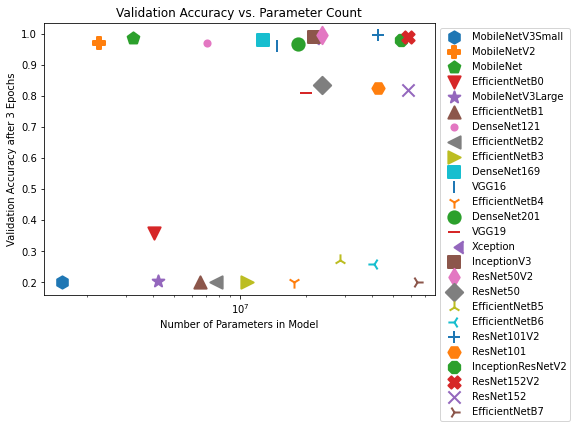

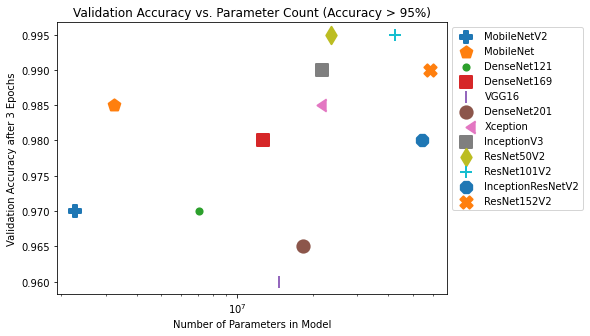

In [146]:
import tensorflow as tf
import inspect
from tqdm import tqdm
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Dense
from keras.models import Sequential
from sklearn.model_selection import train_test_split

# compile all available Keras models
model_dictionary = {m[0]:m[1] for m in inspect.getmembers(tf.keras.applications, inspect.isfunction)}

# split data into training, testing, and validation sets
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, stratify=y_data) # CHANGE to X_data_all
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, stratify=y_train)

# maximum number of epochs for model evaulation
max_epochs = 3

# callback functions
model_dir = os.path.join(os.getcwd(), 'models')
model_checkpoint = ModelCheckpoint(filepath=model_dir, save_best_only=True)
early_stopping = EarlyStopping(monitor='val_categorical_accuracy', 
                            min_delta=0,
                            patience=10,
                            verbose=1,
                            mode='auto',
                            restore_best_weights=True)

# create model
height = X_train.shape[1]
width = X_train.shape[2]
num_categories = y_train.shape[1]
try: 
    assert X_train.shape[3] == 3
except AssertionError:
    print(f'[ERROR] Training data has {X_train.shape[3]} color layers. Model requires 3.')

# Loop over each model available in Keras
model_benchmarks = {'model_name': [], 'num_model_params': [], 'validation_accuracy': []}
for model_name, model in tqdm(model_dictionary.items()):  
    
    # skip NAS models since they require 331x331x3 input shape
    if model_name in ['NASNetLarge', 'NASNetMobile']:
        pass
    else:
        # load the pre-trained model with global average pooling as the last layer and freeze the model weights
        pre_trained_model = model(weights='imagenet', include_top=False, pooling='avg', input_shape=(height, width, 3))
        pre_trained_model.trainable = False
        
        # custom modifications on top of pre-trained model and fit
        clf_model = Sequential()
        clf_model.add(pre_trained_model)
        clf_model.add(Dense(num_categories, activation='softmax'))
        clf_model.compile(
            optimizer='Adam', 
            loss='categorical_crossentropy', 
            metrics=['categorical_accuracy'], 
            )
        history = clf_model.fit(X_train, y_train, epochs=max_epochs, batch_size=64, validation_data=(X_val, y_val), verbose=1, callbacks=[early_stopping, model_checkpoint])

        # Calculate all relevant metrics
        model_benchmarks['model_name'].append(model_name)
        model_benchmarks['num_model_params'].append(pre_trained_model.count_params())
        model_benchmarks['validation_accuracy'].append(history.history['val_categorical_accuracy'][-1])


  0%|                                                                                                                                                                                                                                                                          | 0/28 [00:00<?, ?it/s]

171450368/171446536 [==============================] - 141s 1us/step
Epoch 1/3
29/29 [==============================] - 272s 9s/step - loss: 1.5748 - categorical_accuracy: 0.3343 - val_loss: 1.2682 - val_categorical_accuracy: 0.6000
INFO:tensorflow:Assets written to: C:\Users\clemo\git\gesture_recognition\data_collection_model_preparation\models\assets
Epoch 2/3
29/29 [==============================] - 531s 18s/step - loss: 1.2154 - categorical_accuracy: 0.6204 - val_loss: 1.0365 - val_categorical_accuracy: 0.7400
INFO:tensorflow:Assets written to: C:\Users\clemo\git\gesture_recognition\data_collection_model_preparation\models\assets
Epoch 3/3
29/29 [==============================] - 615s 21s/step - loss: 1.0091 - categorical_accuracy: 0.7471 - val_loss: 0.8914 - val_categorical_accuracy: 0.8250
INFO:tensorflow:Assets written to: C:\Users\clemo\git\gesture_recognition\data_collection_model_preparation\models\assets



 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                         | 20/28 [30:35<12:14, 91.77s/it]

171319296/171317808 [==============================] - 177s 1us/step
Epoch 1/3
29/29 [==============================] - 541s 18s/step - loss: 1.0888 - categorical_accuracy: 0.6215 - val_loss: 0.1544 - val_categorical_accuracy: 0.9750
INFO:tensorflow:Assets written to: C:\Users\clemo\git\gesture_recognition\data_collection_model_preparation\models\assets
Epoch 2/3
29/29 [==============================] - 566s 20s/step - loss: 0.1574 - categorical_accuracy: 0.9580 - val_loss: 0.0859 - val_categorical_accuracy: 0.9850
INFO:tensorflow:Assets written to: C:\Users\clemo\git\gesture_recognition\data_collection_model_preparation\models\assets
Epoch 3/3
29/29 [==============================] - 612s 21s/step - loss: 0.0788 - categorical_accuracy: 0.9843 - val_loss: 0.0599 - val_categorical_accuracy: 0.9950
INFO:tensorflow:Assets written to: C:\Users\clemo\git\gesture_recognition\data_collection_model_preparation\models\assets



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                               | 21/28 [1:06:49<26:54, 230.59s/it]

234700800/234698864 [==============================] - 229s 1us/step
Epoch 1/3
29/29 [==============================] - 1130s 39s/step - loss: 1.5296 - categorical_accuracy: 0.3254 - val_loss: 1.1438 - val_categorical_accuracy: 0.6450
Epoch 2/3
29/29 [==============================] - 985s 34s/step - loss: 1.0815 - categorical_accuracy: 0.7034 - val_loss: 0.8987 - val_categorical_accuracy: 0.7350
Epoch 3/3
29/29 [==============================] - 987s 34s/step - loss: 0.8793 - categorical_accuracy: 0.7552 - val_loss: 0.7529 - val_categorical_accuracy: 0.8200



 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 22/28 [2:02:28<50:05, 500.85s/it]

234553344/234545216 [==============================] - 102s 0us/step
Epoch 1/3
29/29 [==============================] - 914s 31s/step - loss: 1.2103 - categorical_accuracy: 0.5448 - val_loss: 0.1645 - val_categorical_accuracy: 0.9450
Epoch 2/3
29/29 [==============================] - 883s 31s/step - loss: 0.1786 - categorical_accuracy: 0.9438 - val_loss: 0.0743 - val_categorical_accuracy: 0.9850
Epoch 3/3
29/29 [==============================] - 880s 30s/step - loss: 0.0967 - categorical_accuracy: 0.9769 - val_loss: 0.0484 - val_categorical_accuracy: 0.9900
INFO:tensorflow:Assets written to: C:\Users\clemo\git\gesture_recognition\data_collection_model_preparation\models\assets



 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                             | 23/28 [2:51:01<1:03:57, 767.41s/it]

94773248/94765736 [==============================] - 74s 1us/step
Epoch 1/3
29/29 [==============================] - 412s 14s/step - loss: 1.6240 - categorical_accuracy: 0.2295 - val_loss: 1.4434 - val_categorical_accuracy: 0.5300
Epoch 2/3
29/29 [==============================] - 398s 14s/step - loss: 1.4182 - categorical_accuracy: 0.5303 - val_loss: 1.2749 - val_categorical_accuracy: 0.7500
Epoch 3/3
29/29 [==============================] - 394s 14s/step - loss: 1.2571 - categorical_accuracy: 0.6748 - val_loss: 1.1490 - val_categorical_accuracy: 0.8350



 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 24/28 [3:12:21<55:49, 837.30s/it]

94674944/94668760 [==============================] - 8s 0us/step
Epoch 1/3
29/29 [==============================] - 352s 12s/step - loss: 1.3616 - categorical_accuracy: 0.4980 - val_loss: 0.2040 - val_categorical_accuracy: 0.9750
Epoch 2/3
29/29 [==============================] - 343s 12s/step - loss: 0.2321 - categorical_accuracy: 0.9444 - val_loss: 0.1038 - val_categorical_accuracy: 0.9900
Epoch 3/3
29/29 [==============================] - 344s 12s/step - loss: 0.1265 - categorical_accuracy: 0.9771 - val_loss: 0.0711 - val_categorical_accuracy: 0.9950



 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 25/28 [3:29:51<43:36, 872.07s/it]

Epoch 1/3
29/29 [==============================] - 1570s 54s/step - loss: 1.5650 - categorical_accuracy: 0.2718 - val_loss: 1.4398 - val_categorical_accuracy: 0.6600
Epoch 2/3
29/29 [==============================] - 1616s 56s/step - loss: 1.4121 - categorical_accuracy: 0.7185 - val_loss: 1.3035 - val_categorical_accuracy: 0.9000
Epoch 3/3
29/29 [==============================] - 1544s 53s/step - loss: 1.2764 - categorical_accuracy: 0.9302 - val_loss: 1.1871 - val_categorical_accuracy: 0.9600



 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 26/28 [4:48:42<53:21, 1600.99s/it]

80142336/80134624 [==============================] - 7s 0us/step
Epoch 1/3
29/29 [==============================] - 1850s 64s/step - loss: 1.8120 - categorical_accuracy: 0.2187 - val_loss: 1.5418 - val_categorical_accuracy: 0.3650
Epoch 2/3
29/29 [==============================] - 1839s 64s/step - loss: 1.5170 - categorical_accuracy: 0.4717 - val_loss: 1.4246 - val_categorical_accuracy: 0.7700
Epoch 3/3
29/29 [==============================] - 1841s 64s/step - loss: 1.4058 - categorical_accuracy: 0.6140 - val_loss: 1.3214 - val_categorical_accuracy: 0.8100



 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 27/28 [6:21:00<40:37, 2437.49s/it]

83689472/83683744 [==============================] - 10s 0us/step
Epoch 1/3
29/29 [==============================] - 229s 8s/step - loss: 1.0534 - categorical_accuracy: 0.6209 - val_loss: 0.2927 - val_categorical_accuracy: 0.9600
Epoch 2/3
29/29 [==============================] - 221s 8s/step - loss: 0.2619 - categorical_accuracy: 0.9639 - val_loss: 0.1608 - val_categorical_accuracy: 0.9850
Epoch 3/3
29/29 [==============================] - 223s 8s/step - loss: 0.1516 - categorical_accuracy: 0.9823 - val_loss: 0.1213 - val_categorical_accuracy: 0.9850



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 28/28 [6:32:25<00:00, 840.92s/it]


In [173]:
# save results locally
training_date = datetime.datetime.now()
date = training_date.strftime("%Y-%m-%d_T%H_%M")
file_name = date + '_results.json'
file_path = os.path.join(os.getcwd(), 'models', 'results', file_name)
with open(file_path, "w") as outfile:  
    json.dump(model_benchmarks, outfile) 

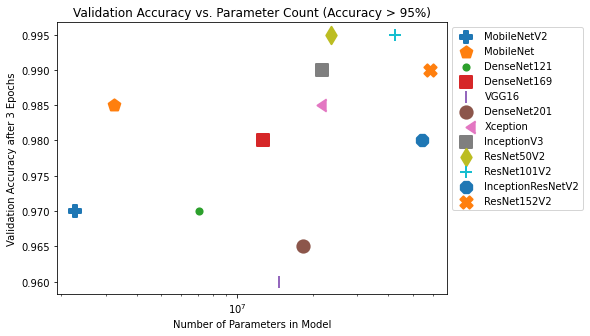

In [194]:
# Plot validation accuracy versus number of parameters for each model
benchmark_df = pd.DataFrame(combined_model_benchmarks)
benchmark_df.sort_values('num_model_params', inplace=True)
benchmark_df = benchmark_df[benchmark_df['validation_accuracy'] > 0.95]

# Loop over each row and plot the num_model_params vs validation_accuracy
markers=[".",",","o","v","^","<",">","1","2","3","4","8","s","p","P","*","h","H","+","x","X","D","d","|","_",4,5,6,7,8,9,10,11]
plt.figure(figsize=(7,5))
for row in benchmark_df.itertuples():
    plt.scatter(row.num_model_params, row.validation_accuracy, label=row.model_name, marker=markers[row.Index], s=150, linewidths=2)
    
plt.xscale('log')
plt.xlabel('Number of Parameters in Model')
plt.ylabel('Validation Accuracy after 3 Epochs')
plt.title('Validation Accuracy vs. Parameter Count (Accuracy > 95%)')
plt.legend(bbox_to_anchor=(1, 1), loc='upper left');

## Training final model
With the MobileNetV2 base model selected, I retrained it using all training images and with a more complex head that included 4 fully-connected dense layers and a dropout layer before the output layer. This worked out well, as the final model performed with 99.8% testing accuracy. 

At this point, I stopped searching for a higher performance model and did not tune the model further, as it seemed that any improvements in accuracy would be minor relative to the amount of time it would take to achieve it. However, based on the plot below of accuracy versus operations for common CNN models, I'm confident that it would be difficult to find a significantly better performing model for this application [1].

![alt text](https://miro.medium.com/max/566/1*Bfm3lhmIfQzyJAmFsL_71Q.png)

One shortcoming of this model is that it was not trained to reject images of non-gestures. Therefore, it will attempt to classify an image of a giraffe rather than reporting "Not recognized." With more time, I would feed the model instances of non-hand-gestures and train it to reject these images rather than label them with whichever of the available hand-gestures they most closely resemble. 

Sources
- [1] https://arxiv.org/pdf/1810.00736.pdf

113/113 [==============================] - 103s 886ms/step - loss: 1.5302 - categorical_accuracy: 0.6172 - val_loss: 0.0289 - val_categorical_accuracy: 0.9887
INFO:tensorflow:Assets written to: C:\Users\clemo\git\gesture_recognition\data_collection_model_preparation\models\assets

 Validation loss: 0.028938310220837593, acc: 0.9887499809265137 


 Training loss: 0.016213100403547287, acc: 0.9952777624130249 


 Testing loss: 0.021608343347907066, acc: 0.9925000071525574 



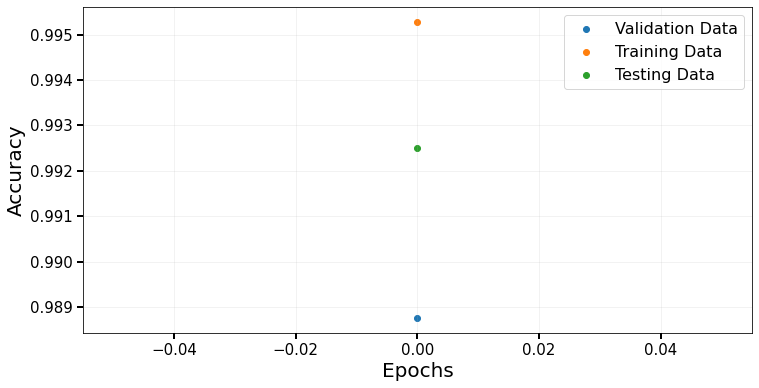

[INFO] Model training took 268.3202016353607 seconds with 7200 data points and 1 epochs.


In [5]:
import time
from keras.applications import MobileNetV2
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Dense, Dropout, Flatten
from keras.models import Model
from sklearn.model_selection import train_test_split

def create_model(height, width, num_categories):
    """Create and return new model.

    Args:
        height (int): Height of image 
        width (int): Width of image
        num_categories (int): Number of gestures to predict 

    Returns:
        model (Tensorflow functional model): built model
    """
    
    # Fetch base model 
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(height, width, 3))

    # Add top to model
    base = base_model.output
    flat = Flatten()(base)
    fc1 = Dense(128, activation='relu', name='fc1')(flat)
    fc2 = Dense(128, activation='relu', name='fc2')(fc1)
    fc3 = Dense(128, activation='relu', name='fc3')(fc2)
    drop = Dropout(0.5)(fc3)
    fc4 = Dense(64, activation='relu', name='fc4')(drop)
    out = Dense(num_categories, activation='softmax')(fc4)
    model = Model(inputs=base_model.input, outputs=out)

    # Train top layers only
    for layer in base_model.layers:
        layer.trainable = False

    return model

# split training data into testing and validation sets
X_train, X_test, y_train, y_test = train_test_split(X_data_all, y_data_all, test_size=0.2, stratify=y_data_all)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, stratify=y_train)

# maximum number of epochs for model evaulation. 
max_epochs = 3

# callback functions
model_dir = os.path.join(os.getcwd(), 'models')
model_checkpoint = ModelCheckpoint(filepath=model_dir, save_best_only=True)

# For this model's application, validation accuracy seems like the most important metric to maximize because it places equal 
# importance on minimizing FP and FN rates rather than just minimizing FP (as with precision) or FN (as with recall)
early_stopping = EarlyStopping(monitor='val_categorical_accuracy', 
                            min_delta=0,
                            patience=10,
                            verbose=1,
                            mode='auto',
                            restore_best_weights=True)

# create model
height = X_train.shape[1]
width = X_train.shape[2]
num_categories = y_train.shape[1]
try: 
    assert X_train.shape[3] == 3
except AssertionError:
    print(f'[ERROR] Training data has {X_train.shape[3]} color layers. Model requires 3.')
model = create_model(height, width, num_categories)
model.compile(
    optimizer='Adam', 
    loss='categorical_crossentropy', 
    metrics=['categorical_accuracy'], 
    )

# monitor accuracy on validation, training, and testing data after each epoch
import matplotlib.pyplot as plt
class EpochAccuracy(tf.keras.callbacks.Callback):
    def __init__(self, val_data, train_data, test_data):
        self.val_data = val_data
        self.train_data = train_data
        self.test_data = test_data
    def on_epoch_end(self, epoch, logs={}):
        epochs.append(epoch)
        # compute accuracy with validation data
        x, y = self.val_data
        loss, acc = self.model.evaluate(x, y, verbose=0)
        val_acc_results.append(acc)
        print('\n Validation loss: {}, acc: {} \n'.format(loss, acc))
        ;
        # compute accuracy with training data
        x, y = self.train_data
        loss, acc = self.model.evaluate(x, y, verbose=0)
        train_acc_results.append(acc)
        print('\n Training loss: {}, acc: {} \n'.format(loss, acc))
        
        # compute accuracy with testing data
        x, y = self.test_data
        loss, acc = self.model.evaluate(x, y, verbose=0)
        test_acc_results.append(acc)
        print('\n Testing loss: {}, acc: {} \n'.format(loss, acc)) 

        # update plot
        fig, ax = plt.subplots(figsize= (12,6))
        ax.scatter(epochs, val_acc_results, label='Validation Data')
        ax.scatter(epochs, train_acc_results, label='Training Data')
        ax.scatter(epochs, test_acc_results, label='Testing Data')
        ax.set_xlabel('Epochs', fontsize=20)
        ax.set_ylabel('Accuracy', fontsize=20)
        ax.tick_params(labelsize=15, labelrotation=0, grid_alpha=0.2, axis='both', which='major', direction='out', length=6, width=2, left=True, bottom=True)
        ax.grid(True)
        ax.legend(loc='upper right', fontsize=16)        
        plt.show()      

val_acc_results = []
train_acc_results = []
test_acc_results = []
epochs = []
start_time = time.time()
history = model.fit(X_train, y_train, epochs=max_epochs, batch_size=64, validation_data=(X_val, y_val), verbose=1, callbacks=[early_stopping, model_checkpoint, EpochAccuracy((X_val, y_val), (X_train, y_train), (X_test, y_test))])
print(f'[INFO] Model training took {time.time() - start_time} seconds with {len(X_train)} data points and {max_epochs} epochs.')

In [181]:
# save model
training_date = datetime.datetime.now()
date = training_date.strftime("%Y-%m-%d_T%H_%M")
model_name = date + '.h5'
model_path = os.path.join(model_dir, model_name)
model.save(model_path)

# compile results
results_dict = {}
results_dict['epochs'] = epochs
results_dict['val_acc'] = val_acc_results
results_dict['train_acc'] = train_acc_results
results_dict['test_acc'] = test_acc_results

# save model and gestures map locally
file_name = date + '_results.json'
file_path = os.path.join(os.getcwd(), 'models', 'results', file_name)
with open(file_path, "w") as outfile:  
    json.dump(results_dict, outfile) 

### Evaluate model
After training the final model, I evaluated its classification performance on the test dataset. Amazingly, the model predicted gestures perfectly, resulting accuracy, recall, precision, and f1-scores of 1. This speaks to the strength of the pre-trained MobileNetV2 model and the impact clean data has on model performance. 

In [10]:
from sklearn.metrics import classification_report, confusion_matrix

def evaluate_model(model, X_test, y_test, labels):
    """Evaluate model performance

    Args:
        model (Tensorflow functional model): trained model
        X_test (array): Array of arrays representing test images
        y_data (array): Array of arrays representing image classification category 
        labels (list): List of gestures

    Returns:
        df_report (Pandas dataframe): Resultant classification report
        df_confusion_matrix (Pandas dataframe): Resultant confusion matrix
    """

    start_time = time.time()

    # evaluate model performance on validation data
    all_preds = model.predict(X_test)
    y_pred = np.argmax(all_preds, axis=1).tolist()
    y_true = np.argmax(np.array(y_test), axis=1).tolist()

    # generate and save classification_report
    report = classification_report(y_true, y_pred, target_names=labels, zero_division=0, output_dict=True)
    df_report = pd.DataFrame(report).transpose()

    # generate and save confusion matrix
    df_confusion_matrix = pd.DataFrame(confusion_matrix(y_true, y_pred), columns=labels, index=labels)   

    eval_time = time.time()-start_time
    print(f'[INFO] Model evaluation took {eval_time} seconds with {len(X_train)} data points. Average prediction time = {eval_time/len(X_train)}')
    
    return [df_report.round(3), df_confusion_matrix]

# Compute model classification report and confusion matrix
labels = list(pd.DataFrame(list(gestures_dict.values()))[1])
[class_report, con_matrix] = evaluate_model(model, X_test, y_test, labels)
print(class_report)
print(con_matrix)

[INFO] Model evaluation took 24.01686978340149 seconds with 7200 data points. Average prediction time = 0.0033356763588057625
              precision  recall  f1-score   support
Open palm         1.000   1.000     1.000   400.000
Closed palm       1.000   0.988     0.994   400.000
L                 0.990   0.990     0.990   400.000
Fist              1.000   0.995     0.997   400.000
Thumbs up         0.973   0.990     0.981   400.000
accuracy          0.992   0.992     0.992     0.992
macro avg         0.993   0.992     0.993  2000.000
weighted avg      0.993   0.992     0.993  2000.000
             Open palm  Closed palm    L  Fist  Thumbs up
Open palm          400            0    0     0          0
Closed palm          0          395    0     0          5
L                    0            0  396     0          4
Fist                 0            0    0   398          2
Thumbs up            0            0    4     0        396


### Predict gesture of sample image
After evaluating the final model, I tested its performance on a specific image to partially verify its functionality. 

Open palm


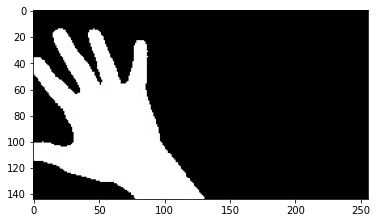

In [12]:
sample_image = os.path.join(os.getcwd(), '2021_01_29_T19_16_17_open_palm_without_glove', 'poor_data', '176.jpg')

def predict_image(path):
    """Predict gesture in image model performance. Return F1-score, evaluation date, evaluation time, predicted values, and true values.

    Args:
        path (str): Path of test image

    Returns:
        pred_index (int): Index of predicted gesture
    """
    
    img = Image.open(path)
    img = np.array(img)
    img = np.array(img, dtype = 'float32')
    img = np.stack((img,)*3, axis=-1) # without comma, (X_data) is np.array not tuple
    img /= 255
    img.resize((1, 144, 256, 3))
    plt.figure()
    plt.imshow(img[0])
    pred_index = np.argmax(model.predict(img))
    return pred_index

pred_index = predict_image(sample_image)
pred_gest = pd.DataFrame(list(gestures_dict.values())).iloc[pred_index][1]
print(pred_gest)